# Neural Network

> Back Propagation Implementation - December 2024
>
> NEC First Assignment - Universitat Rovira i Virgili
>
> *Andrea Pujals Bocero*

## Workflow
1. Initialization
2. Feed-forward propagation
3. Error back-propagation
4. Update of weights and thresholds
5. Training loop
6. Evaluation and visualization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### 1. Initialization
Define parameters in the class constructor. Random initialization of weights to break symmetry. Zero initialization of activations and deltas.

In [2]:
class NeuralNet:
    def __init__(self, layers, epochs, learning_rate, momentum, fact, val_split):
        self.L = len(layers)  # Number of layers
        self.n = layers       # Number of units in each layer
        self.epochs = epochs  # Number of training epochs
        self.lr = learning_rate  # Learning rate
        self.momentum = momentum  # Momentum term
        self.fact = fact  # Activation function
        self.val_split = val_split  # Validation set percentage

        np.random.seed(42)
        # Initialize activations, weights, thresholds, and other variables
        self.h = [None] + [np.zeros(n) for n in layers[1:]]  # Fields
        self.xi = [None] + [np.zeros(n) for n in layers[1:]]  # Activations
        self.w = [None] + [np.random.randn(layers[i], layers[i - 1]) for i in range(1, self.L)]  # Weights
        self.theta = [None] + [np.random.randn(layers[i]) for i in range(1, self.L)]  # Thresholds
        self.delta = [None] + [np.zeros(n) for n in layers[1:]]  # Propagated errors
        self.d_w = [None] + [np.zeros_like(w) for w in self.w[1:]]  # Weight updates
        self.d_theta = [None] + [np.zeros(n) for n in layers[1:]]  # Threshold updates
        self.d_w_prev = [None] + [np.zeros_like(w) for w in self.w[1:]]  # Previous weight updates
        self.d_theta_prev = [None] + [np.zeros(n) for n in layers[1:]]  # Previous threshold updates

        # Loss tracking
        self.train_losses = []
        self.val_losses = []

Activation function method: This method applies a chosen activation function to the input h, determining the output of neurons in a layer.
Activation functions introduce non-linearity, enabling the network to model complex relationships.

Sigmoid function:

$ g(h) = \frac{1}{1 + e^{-h}} $

Relu function:

$ g(h) = \max(0, h) $

Tanh function:

$ g(h) = \tanh(h) $

Linear function:

$ g(h) = h $

In [3]:
    def activation(self, h):
        # Compute the activation function
        if self.fact == 'sigmoid':
            return 1 / (1 + np.exp(-h))
        elif self.fact == 'relu':
            return np.maximum(0, h)
        elif self.fact == 'tanh':
            return np.tanh(h)
        elif self.fact == 'linear':
            return h
        else:
            raise ValueError("Only valid functions: sigmoid, relu, tanh, linear")

Then, the derivative is used during back-propagation to compute the gradient of the loss function with respect to the weights:

Derivative of sigmoid function:

$ g'(h) = g(h) \cdot (1 - g(h)) $

Derivative of relu function:

$ g'(h) =
\begin{cases} 
1 & \text{if } h > 0 \\
0 & \text{otherwise}
\end{cases}
$

Derivative of tanh function:

$ g'(h) = 1 - \tanh^2(h) $

Derivative of linear function:

$ g'(h) = 1 $

In [4]:
    def activation_derivative(self, h):
        # Compute the derivative of the activation function
        if self.fact == 'sigmoid':
            act = 1 / (1 + np.exp(-h))
            return act * (1 - act)
        elif self.fact == 'relu':
            return np.where(h > 0, 1, 0)
        elif self.fact == 'tanh':
            return 1 - np.tanh(h)**2
        elif self.fact == 'linear':
            return np.ones_like(h)
        else:
            raise ValueError("Only valid functions: sigmoid, relu, tanh, linear")

### 2. Feed-forward propagation
The pre-activation field for each layer is computed as:

$ \xi^{(\ell)}_i = g(h^{(\ell)}_i) $

The activation for each unit is computed using an activation function 𝑔:

$h^{(\ell)}_i = \sum_j w^{(\ell)}_{ij} \cdot \xi^{(\ell-1)}_j - \theta^{(\ell)}_i$

In [5]:
    def forward(self, X):
        # Compute forward propagation

        self.xi[0] = X # Input layer activations
        for l in range(1, self.L):
            self.h[l] = np.dot(self.w[l], self.xi[l - 1]) - self.theta[l]
            self.xi[l] = self.activation(self.h[l])
        return self.xi[-1] # Return output layer activations

### 3. Error back-propagation
The error for the output layer L is:

$ \Delta^{(L)}_i = g'(h^{(L)}_i) \cdot (o_i{(x)} - z_i) $

For each hidden layer ℓ, the error is propagated backward:

$ \Delta^{(\ell-1)}_j = g'(h^{(\ell-1)}_j) \cdot \sum_i \Delta^{(\ell)}_i \cdot w^{(\ell)}_{ij} $

In [6]:
    def backward(self, y_true):
        # Compute backward propagation

        # Compute delta for the output layer
        self.delta[-1] = self.activation_derivative(self.h[-1]) * (self.xi[-1] - y_true)

        # Propagate errors backward. Compute deltas for hidden layers (excluding input layer)
        for l in range(self.L - 1, 1, -1):
            self.delta[l - 1] = self.activation_derivative(self.h[l - 1]) * np.dot(self.w[l].T, self.delta[l])

### 4. Update of weights and thresholds
The weights are updated using the delta rule with momentum:

$ \delta w^{(\ell)}_{ij} = -\eta \cdot \Delta^{(\ell)}_i \cdot \xi^{(\ell-1)}_j + \alpha \cdot \delta w^{(\ell)}_{ij, \text{prev}} $

$ w^{(\ell)}_{ij} \to w^{(\ell)}_{ij} + \delta w^{(\ell)}_{ij} $

Thresholds are updated similarly:

$ \delta \theta^{(\ell)}_i = \eta \cdot \Delta^{(\ell)}_i + \alpha \cdot \delta \theta^{(\ell)}_i(\text{prev}) $

$ \theta^{(\ell)}_i \to \theta^{(\ell)}_i + \delta \theta^{(\ell)}_i $

In [7]:
    def update_weights_thresholds(self):
        # Update weights and thresholds using momentum

        for l in range(1, self.L):
            self.d_w[l] = -self.lr * np.outer(self.delta[l], self.xi[l - 1])
            self.w[l] += self.d_w[l] + self.momentum * self.d_w_prev[l]
            self.d_w_prev[l] = self.d_w[l]

            self.d_theta[l] = self.lr * self.delta[l]
            self.theta[l] += self.d_theta[l] + self.momentum * self.d_theta_prev[l]
            self.d_theta_prev[l] = self.d_theta[l]

### 5. Training loop
Loop through epochs, minimize quadratic error:

$ E[o] = \frac{1}{2} \sum_{\mu=1}^p \sum_{i=1}^m (o_i(x^{\mu}) - z_i^{\mu})^2 $

In [8]:
    def fit(self, X, y):
        # Train the neural network

        # Split data into training and validation sets
        n_train = int((1 - self.val_split) * len(X))
        X_train, X_val = X[:n_train], X[n_train:]
        y_train, y_val = y[:n_train], y[n_train:]

        for epoch in range(self.epochs):
            for i in range(len(X_train)):
                self.forward(X_train[i])
                self.backward(y_train[i])
                self.update_weights_thresholds()

            # Compute losses
            train_loss = self.compute_error(X_train, y_train)
            val_loss = self.compute_error(X_val, y_val)
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)

            print(f"Epoch {epoch + 1}/{self.epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}")

### 6. Evaluation and visualization
Evaluating the model’s performance on unseen data (test sets). The predict method corresponds to the output layer’s activations during forward propagation:

$ o(x) = \xi^{(L)} $

In [9]:
    def predict(self, X):
        # Generate predictions. Predict the output for a given input.
        predictions = []
        for x in X:
            self.forward(x)
            predictions.append(self.xi[-1])
        return np.array(predictions)

Error visualization. Training error should decrease.

In [10]:
    def compute_error(self, X, y):
        # Compute the quadratic error
        total_error = 0
        num_samples = len(X)
        for x, y in zip(X, y):
            # Perform feed-forward for each pattern
            self.forward(x)
            # Compute quadratic error for this pattern
            total_error += np.sum((self.xi[-1] - y) ** 2)
        # Return the mean quadratic error across all patterns
        return total_error / num_samples

In [11]:
    def loss_epochs(self):
        # Return the evolution of the training loss and the validation loss
        return self.train_losses, self.val_losses

In [12]:
    def plot_errors(self):
        # Plot training and validation losses
        epochs = np.arange(1, len(self.train_losses) + 1)
        plt.figure(figsize=(10, 6))
        plt.plot(epochs, self.train_losses, label="Training Loss", marker='o')
        plt.plot(epochs, self.val_losses, label="Validation Loss", marker='o')
        plt.title("Training and test error over epochs")
        plt.xlabel("Epochs")
        plt.ylabel("Mean Squared Error (MSE)")
        plt.legend()
        plt.grid()
        plt.show()

### Example of usage

Epoch 1/100, Train Loss: 0.016130477353589634, Val Loss: 0.017463854270034992
Epoch 2/100, Train Loss: 0.00414134938302465, Val Loss: 0.0046760848296548245
Epoch 3/100, Train Loss: 0.0026940589711056, Val Loss: 0.0028570437810867618
Epoch 4/100, Train Loss: 0.0024260457600397594, Val Loss: 0.0024841821645225164
Epoch 5/100, Train Loss: 0.0023086920349503176, Val Loss: 0.0023336946477848105
Epoch 6/100, Train Loss: 0.0022347061867722265, Val Loss: 0.0022438368349557863
Epoch 7/100, Train Loss: 0.0021824019383588173, Val Loss: 0.0021811237955590397
Epoch 8/100, Train Loss: 0.002142649710212111, Val Loss: 0.0021336510764792464
Epoch 9/100, Train Loss: 0.0021105355551819718, Val Loss: 0.002095541935162713
Epoch 10/100, Train Loss: 0.0020831844312392492, Val Loss: 0.0020634311085167448
Epoch 11/100, Train Loss: 0.002058863181769558, Val Loss: 0.002035284385894096
Epoch 12/100, Train Loss: 0.0020365167769421403, Val Loss: 0.002009844081730564
Epoch 13/100, Train Loss: 0.0020155008971184858, 

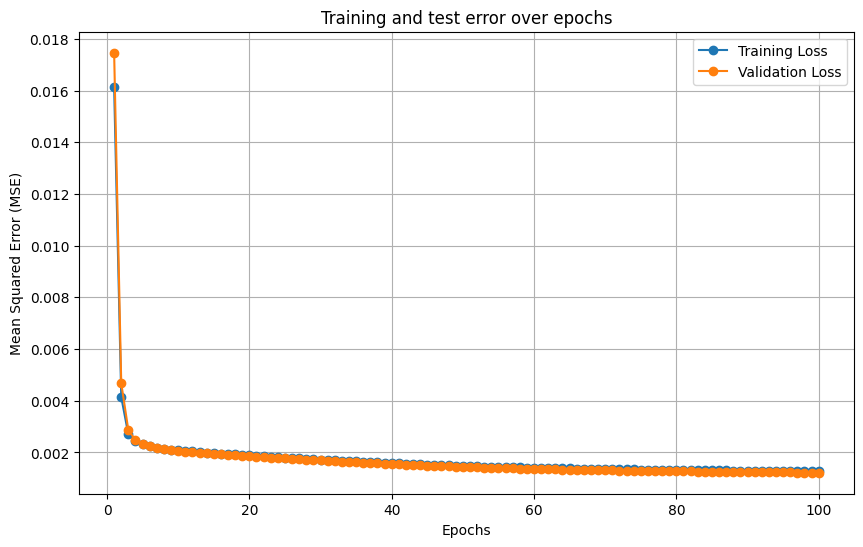

In [17]:
if __name__ == "__main__":
    # Load dataset
    X_train_pd = pd.read_csv('../data/X_train.csv')
    X_test_pd = pd.read_csv('../data/X_test.csv')
    y_train_pd = pd.read_csv('../data/y_train.csv')
    y_test_pd = pd.read_csv('../data/y_test.csv')
    # Convert X_train and X_test to NumPy arrays
    X_train = X_train_pd.to_numpy()
    X_test = X_test_pd.to_numpy()
    # Assuming y_train and y_test have a single target column
    y_train = y_train_pd.to_numpy().ravel()  # Use .ravel() to flatten to 1D array
    y_test = y_test_pd.to_numpy().ravel()

    # Initialize Neural Network
    layers = [9, 8, 4, 1]  # Example: Input layer, two hidden layers, and output layer
    nn = NeuralNet(
        layers=layers,
        epochs=100,
        learning_rate=0.1,
        momentum=0.8,
        fact="sigmoid",
        val_split=0.2
    )

    # Train the Neural Network
    nn.fit(X_train, y_train)

    # Get the training and validation errors
    train_errors, val_errors = nn.loss_epochs()

    # Plot the training and validation errors
    nn.plot_errors()